# 05. 線形SVMによる教師あり学習

---
## 目的
線形SVM(Support Vector Machine)を用いて2つのサンプルを識別する．その後，交差検定法を用いて識別テストを行う．


## プログラムの動作
以下のプログラムを実行すると，`data/car.txt`と`data/human.txt`の2つ読み込む．次に，線形SVMによる学習およびテストを交差検定法を用いて行う．最後に，識別率と識別されたグラフを表示する．




## 準備
プログラムの動作に必要なデータをダウンロードし，zipファイルを解凍する．

In [0]:
!wget -q http://www.mprg.cs.chubu.ac.jp/tutorial/ML_Lecture/sklearn/data.zip
!unzip -q data.zip
!ls
!ls ./data

data  data.zip	__MACOSX  sample_data
car.txt  human.txt


##モジュールのインポート
初めに，必要なモジュールをインポートする．

今回は，SVMを用いるために`SVM`をインポートする．また，精度評価を行うために`metrics`を，交差検定法を用いるため`model_selection`をインポートする．他のモジュールについては第1回目の解説を参照すること．

In [0]:
from os import path
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn import model_selection

##データの読み込み
次に，テキストファイルを読み込む．
これまでと同じであるため，説明は割愛する．

In [0]:
in_txt1 = open(path.join('data', 'car.txt'))
in_txt2 = open(path.join('data', 'human.txt'))

car = np.asarray([(line.strip()).split('\t') for line in in_txt1], dtype=float)
print(car.shape)
human = np.asarray([(line.strip()).split('\t') for line in in_txt2], dtype=float)
print(human.shape)

(110, 2)
(382, 2)


## データのラベル付けと結合，交差検定法の準備
学習を行う前に，データがcarまたはhumanどちらのクラスに属するかラベル付けをする．

In [0]:
car_y =  np.zeros(car.shape[0])
human_y = np.ones(human.shape[0])
X= np.r_[car, human]
y= np.r_[car_y, human_y]

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
print(X.shape, y.shape)

(492, 2) (492,)


基本的に第3回と同じであるが，`kfold = model_selection.KFold(n_splits=5)`は今回が初出である．これは，交差検定法をとしてk-fold法を用いるためのオブジェクトである．

ここでは，`n_splits=5`でデータを5分割するように設定している．

`shuffle=True`は，データをランダムにわけるようにする．例えば，この値が`False`のとき，`学習用データ：[ 1, 2, 3, 4, 5, 6 ]`，`テスト用データ[ 7, 8, 9 ]`のように連番でデータを分割するが，このままだと値が偏ってしまうため，データをランダムに分ける必要がある．

`random_state=0`は，上記のランダム値のシード値である．この値を元にしてランダム値を発生させるため，この値を変えなければ毎回同じランダム値が得られる．通常は「現在時刻」など絶対に二度発生し得ない値を選ぶのだが，今回はテスト条件を統一したいため，値は`0`で固定する．次回以降のプログラムも同じである．


### k-fold法
k-fold法では，データをk個に分割し，そのうち1つをテスト用データ，残りを学習用データとする交差検定法である．テスト用データは持ち回りで選ばれ，合計k回繰り返される．
例えば，データとして9つの数字`[ 1, 2, 3, 4, 5, 6, 7, 8, 9 ]`があると仮定する．`k=3`のとき，データは`[ 1, 2, 3 ]`，`[ 4, 5, 6 ]`，`[ 7, 8, 9 ]`の3つに分けられる．この3つのデータを`k[0]`，`k[1]`，`k[2]`と仮定したとき，1回目のテストは`k[0]`がテスト用データになり，残りは学習用データとなる．2回目は`k[1]`がテスト用データ，3回目は`k[2]`がテスト用データである．このようにして，全てのデータをうまくテストすることができる．なお，結果はk回のテストの平均となる．

![cross_validation.png](https://qiita-image-store.s3.amazonaws.com/0/143078/aa879433-4a18-2690-6caa-16f8868f7af6.png)



## 学習と評価
for文で学習と評価をk回繰り返す．以下，順に説明する．


### 1. リストと変数の初期化
for文の前に，学習とテストに必要なリストと変数を初期化する．

必要なリストおよび変数は次の通りである：

- `scores`: 識別率を記憶するリスト
- `best_score`: k回繰り返すうちの最も良かった識別率を記憶する変数

リストは，`[リスト名].append([新しい要素])`で要素を逐次追加することができる※．


### 2. 学習
学習とテスト，識別率の計算はfor文の中で行う．まずは学習について説明する．

このfor文の書き方はC言語にはないPython独特な書き表し方である．ここでは，変数`train`と`test`にリスト`kfold`で定義されたリストを順番に代入してfor文を回していく．train`に学習用データ，`test`にテスト用データが代入されてループがスタートする．データを入れ替えながらk回繰り返したらループ終了である．

`classifier = svm.LinearSVC(C=0.1, random_state=0)`では，第3回と同じように識別器の設定を行う．`LinearSVC`が線形SVMの識別器を表す．パラメータは，誤識別をどれだけ許容するかを表す`C=0.1`と，データをランダムにする`random_state=0`である．k-foldと同じ理由から，`random_state`は`0`のまま固定にしておく．

用意した識別器を用いて学習を行う方法は第4回のkNNと同じである．


### 3. テスト
学習と同じく，テストも簡単に行える．

`classifier.predict(X[test])`は，テストデータがどのクラスに属するかをテストである．リスト`preds`はテストの結果が代入される．次に，`metrics.accuracy_score(preds, y[test])`は先ほどのテストで得られた結果と正解ラベル`y[test]`を比べて検出率を計算する．変数`score`には検出率が代入される．


### 4. 最も良かったスコアと識別器の記録
もし，テスト結果が今までで一番良かった場合は識別機を記憶する．

現時点でのベストスコアよりも高いスコアが出た場合，学習済み識別器を保管し，ベストスコアを更新する．


※「リスト」と「配列」は用意されている機能（関数）が大きく違っているが，基本的な使い方（添字でのアクセス等）は同じである．今回はリストでしか行えない処理（`append`）を行うためリストを用いる．numpyの「配列」にも`append`関数はあるが，挙動が違うためここではPython標準のリストを用いる．どの変数が配列でどの変数がリストか注意すること．


In [0]:
# 1. リストと変数の初期化
scores = []
best_score = 0.0

# 2. 学習
for train, test in kfold.split(X):
    classifier = svm.LinearSVC(C=0.1, random_state=0)
    classifier.fit(X[train], y[train])
    
    # 3. テスト
    preds = classifier.predict(X[test])
    score = metrics.accuracy_score(preds, y[test])
    scores.append(score)

    # 4. 最も良かったスコアと識別器の記録
    if score > best_score:
        best_classifier = classifier
        best_score = score

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## 識別率の計算
得られたk個の結果を平均して，識別率を求める．

`sum(リスト)`でリストの合計，`len(リスト)`でリストの要素数を求め，平均値を出し，100倍して百分率の値にする．次の行では，結果を画面に表示するために文字を整形する．`'{accuracy:.2f}%'.format(accuracy=accuracy)`は`accuracy`を小数点第2位まで表示となる．．C言語の`printf`のような記述方法も可能である．興味のある人は調べてみると良い．整形したテキストは次の行でprintされる．

In [0]:
accuracy = (sum(scores) / len(scores)) * 100
msg = 'recognition rate: {accuracy:.2f}%'.format(accuracy=accuracy)
print(msg)

recognition rate: 80.28%


## グラフの描画
識別結果を可視化するために，先程求めた「最も識別率の良かった学習データを学習させてある識別器」を用いて，グラフを作成する．どちらのクラスがどの領域かわかりやすく表示することができる．

第3回でも用いた`meshgrid`と，等高線を描画する`contour`を用いる，今回は等高線を塗りつぶして2つのクラスをエリアのように表示するため，塗りつぶす等高線`contourf`を用いる．他は第3回目とほとんど同じである．

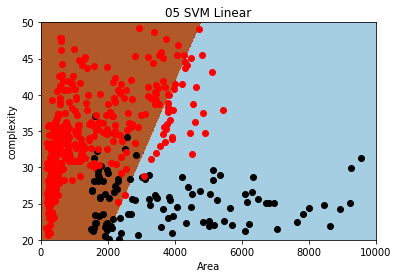

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure()
subfig = fig.add_subplot(1,1,1)
plt.xlim(0, 10000)
plt.ylim(20, 50)

xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 500),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 500))

Z = best_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

subfig.scatter(car[:,0], car[:,1],color='black')
subfig.scatter(human[:,0], human[:,1],color='red')

subfig.set_title('05 SVM Linear')
subfig.set_xlabel('Area')
subfig.set_ylabel('complexity')

plt.savefig("05_graph.png")
plt.show()

## 課題
1. 線形SVMのパラメータ`C`の値を変えると識別境界はどう変化するか．
2. より識別率が高くなる`C`の値を求めよ．


## ヒント
1. `C`は誤識別サンプルに対するペナルティを示す．グラフを表示して確かめてみる．
2. ある値より高くすると変化しなくなる．高すぎても，低すぎても良くない．